# Customer Satisfication Prediction using Machine Learning

The company is one of the fastest growing startups in the logistics and delivery domain and works with several partners and make on-demand delivery to our customers. The company wants to to measure how happy each customer is in order to grow with the right global expansion strategy.

The company provides me a dataset of several customer feedback and a label whether the customer is happy.

## Goal

- Predict if a customer is happy or not based on the answers they give to questions asked. The company is aiming for 73% accuracy score or above
- Find which questions/features are more important when predicting a customer’s happiness


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
import xgboost as xgb

# accuracy metrics
from sklearn.metrics import classification_report, f1_score, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

## Data exploration

In [ ]:
# understanding the data
df = pd.read_csv('HappinessSurvey2020.csv')

df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


### Data Description

* Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers 
* X1 = my order was delivered on time
* X2 = contents of my order was as I expected
* X3 = I ordered everything I wanted to order
* X4 = I paid a good price for my order
* X5 = I am satisfied with my courier
* X6 = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

In [3]:
# Checking for NaN
df.isna().sum()

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

There is no NaN value that we have to handle in this example.

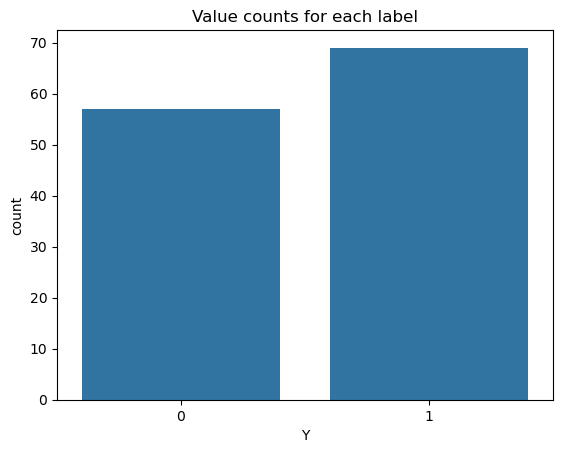

In [4]:
label_counts = df['Y'].value_counts()
sns.countplot(x='Y', data=df)
plt.title('Value counts for each label')
plt.show()

In [5]:
# Find the difference between two classes
print(f"class 0 accounts for {(len(df[df['Y'] == 0])/len(df)) * 100:.2f}% out of 100%")

class 0 accounts for 45.24% out of 100%


We can see that the label is slightly imbalanced but it's only 5% difference so I don't think we need to handle this issue

## Data Skewness

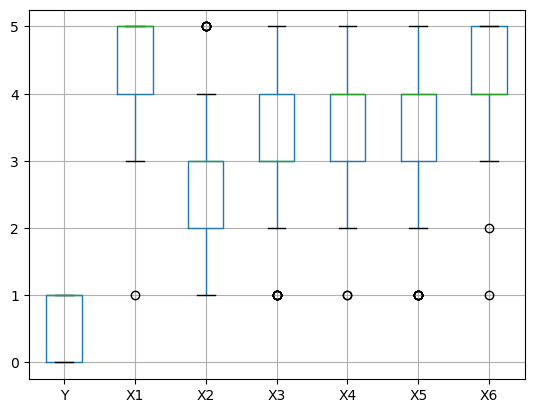

In [6]:
df.boxplot()
plt.show()

In [7]:
df.skew()

Y    -0.193659
X1   -1.058468
X2    0.271000
X3   -0.199536
X4   -0.422240
X5   -0.699999
X6   -0.957590
dtype: float64

* I can see that most features have left-skewed distribution which lead to negative skewness. This should be handled before we train the data since the skewness will affect the performance of the data.
* I choose to do boxcox for X1 and X6 since these 2 features are highly skewed and sqrt for X5. 

In [8]:
df['X1'], _ = stats.boxcox(df['X1'])
df['X6'], _ = stats.boxcox(df['X6'])
df['X5'], _ = stats.boxcox(df['X5'])

In [9]:
# Check skewness after the tranformation
df.skew()

Y    -0.193659
X1   -0.381695
X2    0.271000
X3   -0.199536
X4   -0.422240
X5   -0.274511
X6   -0.278770
dtype: float64

## Data Correlation in order to select features

In [10]:
df.corr()['Y']

Y     1.000000
X1    0.292396
X2   -0.024274
X3    0.150838
X4    0.064415
X5    0.227385
X6    0.171459
Name: Y, dtype: float64

X5 has the highest linear correlation to the label while X2 has very low correlation to the label. 
Therfore, I will remove this feature from the model

In [11]:
y = df['Y']
x = df.drop(columns=['Y','X2'])

## Model Training

In [12]:
# split the data to train and test dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [ ]:
# Model that I am going to implement for the prediction
models = ['LogisticRegression','KNeighborsClassifier','RandomForestClassifier', 'DecisionTreeClassifier', 'SVC', 'xgb']

# Parameter that I will use for the model tuning through GridSearchCV
param_grid = dict()
param_grid['LogisticRegression'] = {'C': [1/0.0001, 1/0.001, 1/0.01, 1/0.1]} # inverse of regularization term 

param_grid['DecisionTreeClassifier'] = {'criterion': ['entropy', 'log_loss', 'gini'], # measure of impurity
                                        'max_depth': [3, 5, 10, None], # how many levels does the tree have?
                                        'min_samples_split': [2, 3, 4, 5], # how many samples are needed to make a split?
                                       }
param_grid['RandomForestClassifier'] = {'n_estimators': [200, 300, 400, 500], # number of trees in the forest
                                        'max_depth': np.arange(1, len(X_train.columns), 1), # how many levels does the tree have?
                                        'min_samples_split': [3, 4, 5], # how many samples are needed to make a split?
                                       } 
param_grid['KNeighborsClassifier'] = {'n_neighbors' : np.arange(2, 40, 2)} # how many neighbors should be group together? 

param_grid['SVC'] = {'C': [0.0001, 0.001, 0.01, 0.1], # regularization term
                     'kernel': ['rbf', 'linear', 'poly'] # kernel trick method
                     }
param_grid['xgb'] = {'n_estimators': [500, 1000, 1500, 2000], # number of trees in the forest
                    'max_depth': [3, 4, 5], # max depth of the trees
                    'learning_rate': [0.01, 0.1, 0.05], # learning rate for each round
                    'gamma': [0, 1, 2], # regularization term
                    'min_child_weight': [1, 3, 5], # minimum sum of the weight for each child(leaf) in the tree
                    'gamma': [0, 1, 2], # regularization term
                    'subsample': [0.8, 1.0]} # regularization term

# Function to load the model
def load_model(model):
    if model == 'LogisticRegression':
        return LogisticRegression()
    elif model == "DecisionTreeClassifier":
        return DecisionTreeClassifier(random_state=42)
    elif model == 'RandomForestClassifier':
        return RandomForestClassifier(random_state=42)
    elif model == 'KNeighborsClassifier':
        return KNeighborsClassifier()
    elif model == 'SVC':
        return SVC(random_state=42)
    elif model == 'xgb':
        return xgb.XGBClassifier()


In [ ]:
best_model = ""
best_score = 0

for model in models:
    gs = GridSearchCV(estimator = load_model(model), param_grid = param_grid[model], 
                      cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42))
    gs.fit(X_train, y_train)
    model_param = gs.best_estimator_
    y_pred_test = model_param.predict(X_test)
    test_score = 0
    test_score = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    print(f"Model : {model_param}")
    print(f"Score from Test Set : {test_score}, F1-score : {f1}")
    print(classification_report(y_test, y_pred_test))
    if test_score > best_score:
        best_score = test_score
        best_model =  model_param

    y_pred_train = model_param.predict(X_train)
    train_score = accuracy_score(y_train, y_pred_train)
    print(f"Score from Train Set : {train_score}")

print(f"Best model is :{best_model} with the test score of {best_score}")

Model : LogisticRegression(C=10000.0)
Score from Test Set : 0.6153846153846154, F1-score : 0.6666666666666666
              precision    recall  f1-score   support

           0       0.67      0.46      0.55        13
           1       0.59      0.77      0.67        13

    accuracy                           0.62        26
   macro avg       0.63      0.62      0.61        26
weighted avg       0.63      0.62      0.61        26

Score from Train Set : 0.56
Model : KNeighborsClassifier(n_neighbors=8)
Score from Test Set : 0.6923076923076923, F1-score : 0.7333333333333333
              precision    recall  f1-score   support

           0       0.78      0.54      0.64        13
           1       0.65      0.85      0.73        13

    accuracy                           0.69        26
   macro avg       0.71      0.69      0.68        26
weighted avg       0.71      0.69      0.68        26

Score from Train Set : 0.76
Model : RandomForestClassifier(max_depth=2, min_samples_split=3,

# Conclusion

### Model performance

| Model | Test Score (Accuracy) | Test Score (F-1 Score) | Train Score (Accuracy) |
|-------|-------------|----------| ----- |
| Logistic Regression | 0.61 | 0.66 | 0.56 |
| KNN | 0.69| 0.73 | 0.76 |
| Random Forest| 0.61 | 0.66 | 0.69 |
| Decision Tree | 0.50 | 0.55 | 0.71 |
| SVC | 0.73 | 0.74 | 0.63 |
| XGBoost | 0.57 | 0.62 | 0.89 |



The SVC model performed the best with a test accuracy of 73% and an F1 score of 74%, which is slightly higher due to the class imbalance in the dataset. SVC tends to handle small datasets better than more complex models like XGBoost, which typically performs well on larger datasets. Given the small size of the dataset, SVC's simpler model structure allows it to generalize better and avoid overfitting compared to more complex models that might require more data to fully capture patterns.

### Feature Selection

In terms of features, X5 ("I am satisfied with my courier") has the highest correlation with customer satisfaction, followed by X1 ("My order was delivered on time"), which both related to the shipment. X2 ("Contents of my order was as I expected") shows the lowest correlation.

I would suggest the company to gather more feedbacks related to the shipment process and potentially remove X2 feature from the future surveys to enhance the company's predictive capabilities and growth potential.